#  Use SARIMAX to model the time series process 

# Define global variable(train_end, predict_start, predict_end) and common functions

Define train and predict windows 

In [1]:
# for development 
# train_end='2019-6'
# predict_start='2019-7'
# predict_end='2019-9'

# for final submit 
train_end='2019-9'
predict_start='2019-10'
predict_end='2019-12'

## Auto_arima Function
note the d is default at  0 and trace =True. Can turn it off or change

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
import pmdarima as pm 
def auto_arima(df,col_exog,d=0):
    try:
        results=pm.auto_arima(df[['stock_distributed']],
                              exog=df[col_exog],
                              seasonal=True,information_criterion='bic',m=12,
                          d=d, D=0, 
                          max_p=4, max_q=4, 
                          trace=True, # can turn Trace off 
                          error_action='ignore',
                          suppress_warnings=True)
        print(results.order)
        print(results.seasonal_order)
        #print(col_exog)
        return[results.order,results.seasonal_order] 
    except:
        print('error searching')

## SARIMAX - Individual

It's individual specific because the df_pred_agg_results_piece. The result collection part and the plot part assumes df is on individual level 

In [4]:

def predict_sarimax(df,order,seasonal_order,col_exog,plot=0):
    try:
        df_train=df[:train_end]
        df_test=df[predict_start:predict_end]
        model = SARIMAX(df_train['stock_distributed'], order=order,seasonal_order=seasonal_order,
                        exog=df_train[col_exog])
        result=model.fit()
        sarima_mean_insample=result.get_prediction(start=df_train.index[0],end=train_end,
                                                   exog=df_train[col_exog]).predicted_mean
        sarima_mean_outsample=result.get_prediction(start=predict_start,end=predict_end,
                                                    exog=df[predict_start:predict_end][col_exog]).predicted_mean
        sarima_mean_prediction=sarima_mean_insample.append(sarima_mean_outsample)
        site_code=df.iloc[0].site_code
        product_code=df.iloc[0].product_code
        
        df_pred_agg_results_piece=pd.DataFrame(data=sarima_mean_prediction,columns=['stock_distributed_forecasted'])
        df_pred_agg_results_piece['site_code']=site_code
        df_pred_agg_results_piece['product_code']=product_code 
        if plot==1:
            pd.DataFrame({'insample_pred':sarima_mean_insample,'outsample_pred':sarima_mean_outsample,'actual_value':df['stock_distributed']}).plot(); 
            plt.title(site_code+"--"+product_code)
            plt.show()
        return df_pred_agg_results_piece
    except:
        print('error')

# Import and process data 

## Import '../0_data/df_combined_fullsample.csv'

In [5]:
import pandas as pd
 #  contraceptive_logistics=pd.read_csv('../0_data/df_combined.csv') 
contraceptive_logistics=pd.read_csv('../0_data/df_combined_fullsample.csv')
contraceptive_logistics['day']=1
contraceptive_logistics['date']=pd.to_datetime(contraceptive_logistics[['year','month','day']])
contraceptive_logistics=contraceptive_logistics.sort_values('date')

## Winsorize stock_distributed

In [6]:
contraceptive_logistics['max']=contraceptive_logistics.groupby(['site_code','product_code'])['stock_distributed'].transform('max')
contraceptive_logistics['std']=contraceptive_logistics.groupby(['site_code','product_code'])['stock_distributed'].transform('std')
contraceptive_logistics['mean']=contraceptive_logistics.groupby(['site_code','product_code'])['stock_distributed'].transform('mean')
contraceptive_logistics['stock_distributed_clip']=contraceptive_logistics['stock_distributed'].clip(0,contraceptive_logistics['mean']+2*contraceptive_logistics['std'])
contraceptive_logistics['stock_distributed']=contraceptive_logistics['stock_distributed_clip']

## Simplify to individual level 

In [7]:
ind_level_stocks=contraceptive_logistics.groupby(['region','site_code','product_code','date'])['stock_distributed'].sum()
df_ind_level_stocks=pd.DataFrame(data=ind_level_stocks)
df_ind_level_stocks=df_ind_level_stocks.reset_index()
len(df_ind_level_stocks)

44504

In [8]:
col_continuous=contraceptive_logistics.columns[10:-1].to_list()
col_continuous.remove('site_type')
for col in col_continuous:
    print(col)
    df_ind_level_stocks[col]=pd.DataFrame(data=contraceptive_logistics.groupby(['region','site_code','product_code','date'])[col].mean().values)


regionasphaltroads
regionearthroads
regionsurfacetreatmentroads
regionpoorroads
poorroads
earthroads
asphaltroads
temp
maxtemp
pressure
relativehumidity
rainfallsnowmelt
visibility
windspeed
maxsustainedwindspeed
rainordrizzle
storm
fog
day
max
std
mean


# SARIMAX

In [9]:
col_continuous=contraceptive_logistics.columns[10:-1].to_list()
col_continuous.remove('site_type')

In [10]:
col_exog=col_continuous

### Testing  

C1054
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=451.042, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=444.975, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=441.305, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=445.049, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=471.166, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=438.058, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=441.359, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=445.140, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=439.382, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=440.492, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=441.989, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=443.134, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=442.189, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.227 seconds
(1, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


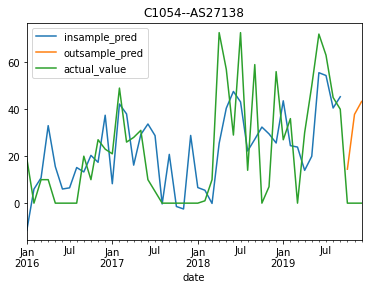

C1054
AS42018
C1059
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=253.979, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=255.299, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=255.503, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=265.015, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=255.702, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=255.048, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=252.196, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=255.022, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=254.978, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=253.651, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=253.485, Time=0.02 sec
 ARIMA(2,0,1)(0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


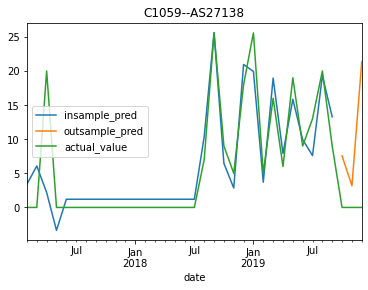

C1059
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-594.401, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
error


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
# testing look , plot=1 
df_pred_ind=pd.DataFrame()
for site_code in  df_ind_level_stocks['site_code'].unique()[6:8] :
    df1=df_ind_level_stocks[df_ind_level_stocks['site_code']==site_code];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(site_code)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_ind=pd.concat([df_pred_ind,result_piece])


## Export  '../2_pipeline/final_pred_ind_lev.csv' 
## Run the full data 

In [ ]:
df_pred_ind=pd.DataFrame()
for site_code in  df_ind_level_stocks['site_code'].unique() :
    df1=df_ind_level_stocks[df_ind_level_stocks['site_code']==site_code];
    for product in df1['product_code'].unique():
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(site_code)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=0);
            # print(result_piece)
            df_pred_ind=pd.concat([df_pred_ind,result_piece])
df_pred_ind.to_csv('../2_pipeline/final_pred_ind_winsorized_lev.csv')